In [123]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

%matplotlib inline

# Data

In [382]:
data_path = '/home/calvinku/Projects/autoencoder_zoo/data'
valid_size = 0.25
BATCH_SIZE = 64

# # MNIST
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize((0.1307,), (0.3081,))
#                                     ])

# transform_test = transforms.Compose([transforms.ToTensor(),
#                                      transforms.Normalize((0.1307,), (0.3081,))
#                                     ])

# training_set = datasets.MNIST(root=data_path, train=True, download=True, transform=transform_train)
# validation_set = datasets.MNIST(root=data_path, train=True, transform=transform_test)
# test_set = datasets.MNIST(root=data_path, train=False, transform=transform_test)

# Load CIFAR10 dataset
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                      ])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                    ])

training_set = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform_train)
validation_set = datasets.CIFAR10(root=data_path, train=True, transform=transform_test)
test_set = datasets.CIFAR10(root=data_path, train=False, transform=transform_test)


num_train = len(training_set)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, sampler=valid_sampler)

full_train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


# Model
## k-sparse Autoencoder

In [383]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, x.size(1) * x.size(2) * x.size(3))
    
class kSparseAE(nn.Module):
    def __init__(self, k, num_hiddens):
        super().__init__()
        self.k = k
        self.num_hiddens = num_hiddens
                
        self.flatten = Flatten()
        self.encoder = nn.Linear(784, self.num_hiddens)
        self.decoder = nn.Linear(self.num_hiddens, 784)
                
    def forward(self, x):
        batch_size, channel, height, width = x.shape
        
        x = self.flatten(x)
        x = self.encoder(x)
        
        # Enforce k-sparsity
        topk, indices = torch.topk(x, self.k)
        res = Variable(torch.zeros(x.shape[0], x.shape[1]))
        res = res.scatter(1, indices, topk)
        
        x = self.decoder(res)
        x = x.view(-1, channel, height, width)
        
        return x

In [384]:
class kSparseCAE(nn.Module):
    def __init__(self, num_hiddens, k, alpha):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.k = k
        self.alpha = alpha
        
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        
        self.flatten = Flatten()
        self.encoder = nn.Linear(1024, self.num_hiddens)
        self.decoder = nn.Linear(self.num_hiddens, 1024)
#         self.encoder = nn.Linear(784, self.num_hiddens)
#         self.decoder = nn.Linear(self.num_hiddens, 784)
        
        self.deconv1 = nn.ConvTranspose2d(1, 16, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1)
#         self.deconv4 = nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x, ind1 = self.maxpool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
#         x, ind2 = self.maxpool2(x)
        
        batch_size, channel, height, width = x.shape
        
        x = self.flatten(x)
        x = self.encoder(x)
        
        # Enforce k-sparsity
        if self.training:
            topk, indices = torch.topk(x, self.k)
        else:
            topk, indices = torch.topk(x, self.k * self.alpha)
#             topk_min = topk.clone().cpu().detach().numpy().min()
#             print("Test time, topk = {}".format(topk_min))
            
        res = Variable(torch.zeros(x.shape[0], x.shape[1]))
        
        if torch.cuda.is_available():
            topk = topk.cuda()
            res = res.cuda()
            
        res = res.scatter(1, indices, topk)
        
        x = self.decoder(res)
        
        x = x.view(-1, channel, height, width)
        
#         x = self.maxunpool1(x, ind2)
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = F.relu(x)
#         x = self.maxunpool2(x, ind1)
        x = self.deconv3(x)
        x = self.deconv4(x)
        
        return x

In [385]:
def train(model, train_loader, test_loader, valid_size, epochs, cuda=False, verbose=1, log_interval=100):
    start_time = time.time()

    if valid_size is not None:
        num_rows = len(train_loader.dataset) - int(np.floor(valid_size * len(train_loader.dataset)))
    else:
        num_rows = len(train_loader.dataset)

    loss_func = nn.L1Loss()
#     loss_func = nn.MSELoss()
    model.train() 
    state_dict = None
    restart_epoch_list = [1]
    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs + 1):
        if torch.cuda.is_available() and cuda:
            model = model.cuda()

            if not next(model.parameters()).is_cuda:
                raise TypeError("model.cuda() is not working!")

        else:
            model = model.cpu()

        # SGDR Warm start
        if epoch in restart_epoch_list:
            optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.0001, nesterov=True)

            if state_dict is not None:
                optimizer.load_state_dict(state_dict)

            # optim_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader),
            #                                                        eta_min=0, last_epoch=-1)
            optim_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                                   T_max=len(train_loader) * 2 ** (len(restart_epoch_list) - 1),
                                                                   eta_min=0, last_epoch=-1)
            # Do learning rate decay, decay in every iteration
            optim_scheduler.step()

        for batch_idx, (data, target) in enumerate(train_loader):
            if torch.cuda.is_available() and cuda:
                data, target = data.cuda(), target.cuda()
            else:
                data, target = data.cpu(), target.cpu()

            data, target = Variable(data), Variable(target)

            optimizer.zero_grad()
            output = model(data)

            # Cross entropy loss
            loss = loss_func(output, data)
            loss[(loss != loss) | (loss == float("Inf"))] = 100
            loss_clamped = loss
            loss_sum = loss_clamped.mean()
            
            train_losses.append(loss_sum.data.item())

            try:
                loss_sum.backward()
            except RuntimeError:
                for weight in model.parameters():
                    try:
                        print(weight.size(), weight.grad.size())
                    except AttributeError:
                        print(weight.size(), None)

            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Validation loss: {:.6f}'.format(
                    epoch, batch_idx * len(data), num_rows,
                    100. * batch_idx * len(data) / num_rows, loss_sum.data.item()))

        loss = test(model, test_loader, cuda=cuda)
        test_losses.append(loss)
        
        state_dict = optimizer.state_dict()
        restart_epoch_list.append(restart_epoch_list[-1] + 2**(epoch - 1))

    print("Training took {} seconds\n".format(round(time.time() - start_time, 2)))

    return train_losses, test_losses

def test(model, test_loader, cuda=False, verbose=True):
    # pdb.set_trace()
    if torch.cuda.is_available() and cuda:
        model = model.cuda()
    else:
        model = model.cpu()

    model.eval()

    loss_func = nn.L1Loss()
#     loss_func = nn.MSELoss()
    test_loss = 0
    num_rows = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            if torch.cuda.is_available() and cuda:
                data, target = data.cuda(), target.cuda()
            else:
                data, target = data.cpu(), target.cpu()

            data, target = Variable(data), Variable(target)
            num_rows += data.size(0)

            output = model(data)

            test_loss += loss_func(output, data).mean()
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        # test_loss /= len(test_loader.dataset)
        test_loss /= num_rows
        # loss_sum /= num_rows

        if verbose:
            print("Test set: Average loss: {:.4f}\n".format(test_loss))

    return test_loss.data.item()

In [386]:
# [70, 40, 25, 10]
epochs = 63
k = 150
alpha = 2
num_hiddens = 4000

model = kSparseCAE(num_hiddens, k, alpha)
# model = nn.DataParallel(model)

In [387]:
train_losses, test_losses = train(model, train_loader, valid_loader, valid_size, epochs, cuda=True, verbose=1, log_interval=100)

Train Epoch: 1 [0/37500 (0%)]	 Validation loss: 0.819415
Train Epoch: 1 [6400/37500 (17%)]	 Validation loss: 0.770261
Train Epoch: 1 [12800/37500 (34%)]	 Validation loss: 0.839345
Train Epoch: 1 [19200/37500 (51%)]	 Validation loss: 0.846105
Train Epoch: 1 [25600/37500 (68%)]	 Validation loss: 0.867791
Train Epoch: 1 [32000/37500 (85%)]	 Validation loss: 0.860016
Test set: Average loss: 0.0130

Train Epoch: 2 [0/37500 (0%)]	 Validation loss: 0.816359
Train Epoch: 2 [6400/37500 (17%)]	 Validation loss: 0.866377
Train Epoch: 2 [12800/37500 (34%)]	 Validation loss: 0.837464
Train Epoch: 2 [19200/37500 (51%)]	 Validation loss: 0.838564
Train Epoch: 2 [25600/37500 (68%)]	 Validation loss: 0.831866
Train Epoch: 2 [32000/37500 (85%)]	 Validation loss: 0.840879
Test set: Average loss: 0.0130

Train Epoch: 3 [0/37500 (0%)]	 Validation loss: 0.816011
Train Epoch: 3 [6400/37500 (17%)]	 Validation loss: 0.818731
Train Epoch: 3 [12800/37500 (34%)]	 Validation loss: 0.887560
Train Epoch: 3 [19200/37

Train Epoch: 21 [19200/37500 (51%)]	 Validation loss: 0.308802
Train Epoch: 21 [25600/37500 (68%)]	 Validation loss: 0.325302
Train Epoch: 21 [32000/37500 (85%)]	 Validation loss: 0.295818
Test set: Average loss: 0.0051

Train Epoch: 22 [0/37500 (0%)]	 Validation loss: 0.334832
Train Epoch: 22 [6400/37500 (17%)]	 Validation loss: 0.290941
Train Epoch: 22 [12800/37500 (34%)]	 Validation loss: 0.285702
Train Epoch: 22 [19200/37500 (51%)]	 Validation loss: 0.278612
Train Epoch: 22 [25600/37500 (68%)]	 Validation loss: 0.304525
Train Epoch: 22 [32000/37500 (85%)]	 Validation loss: 0.292256
Test set: Average loss: 0.0044

Train Epoch: 23 [0/37500 (0%)]	 Validation loss: 0.290444
Train Epoch: 23 [6400/37500 (17%)]	 Validation loss: 0.271193
Train Epoch: 23 [12800/37500 (34%)]	 Validation loss: 0.307578
Train Epoch: 23 [19200/37500 (51%)]	 Validation loss: 0.292719
Train Epoch: 23 [25600/37500 (68%)]	 Validation loss: 0.298815
Train Epoch: 23 [32000/37500 (85%)]	 Validation loss: 0.342177
Tes

Train Epoch: 41 [32000/37500 (85%)]	 Validation loss: 0.243013
Test set: Average loss: 0.0039

Train Epoch: 42 [0/37500 (0%)]	 Validation loss: 0.239175
Train Epoch: 42 [6400/37500 (17%)]	 Validation loss: 0.264473
Train Epoch: 42 [12800/37500 (34%)]	 Validation loss: 0.239068
Train Epoch: 42 [19200/37500 (51%)]	 Validation loss: 0.240616
Train Epoch: 42 [25600/37500 (68%)]	 Validation loss: 0.270291
Train Epoch: 42 [32000/37500 (85%)]	 Validation loss: 0.235863
Test set: Average loss: 0.0039

Train Epoch: 43 [0/37500 (0%)]	 Validation loss: 0.251682
Train Epoch: 43 [6400/37500 (17%)]	 Validation loss: 0.234014
Train Epoch: 43 [12800/37500 (34%)]	 Validation loss: 0.262265
Train Epoch: 43 [19200/37500 (51%)]	 Validation loss: 0.263350
Train Epoch: 43 [25600/37500 (68%)]	 Validation loss: 0.241469
Train Epoch: 43 [32000/37500 (85%)]	 Validation loss: 0.241920
Test set: Average loss: 0.0041

Train Epoch: 44 [0/37500 (0%)]	 Validation loss: 0.261799
Train Epoch: 44 [6400/37500 (17%)]	 Val

Train Epoch: 62 [6400/37500 (17%)]	 Validation loss: 0.244224
Train Epoch: 62 [12800/37500 (34%)]	 Validation loss: 0.244750
Train Epoch: 62 [19200/37500 (51%)]	 Validation loss: 0.217523
Train Epoch: 62 [25600/37500 (68%)]	 Validation loss: 0.223034
Train Epoch: 62 [32000/37500 (85%)]	 Validation loss: 0.248310
Test set: Average loss: 0.0037

Train Epoch: 63 [0/37500 (0%)]	 Validation loss: 0.225839
Train Epoch: 63 [6400/37500 (17%)]	 Validation loss: 0.252392
Train Epoch: 63 [12800/37500 (34%)]	 Validation loss: 0.255406
Train Epoch: 63 [19200/37500 (51%)]	 Validation loss: 0.240519
Train Epoch: 63 [25600/37500 (68%)]	 Validation loss: 0.243288
Train Epoch: 63 [32000/37500 (85%)]	 Validation loss: 0.237780
Test set: Average loss: 0.0039

Training took 1616.95 seconds



In [388]:
# filters = model.encoder.weight.data.view(-1, 1, 28, 28)
filters = model.encoder.weight.data.cpu()
filters = filters.numpy()

In [389]:
filters.shape

(4000, 1024)

In [390]:
filter_max = filters.max(1)
filter_min = filters.min(1)
denom = (filter_max - filter_min).reshape(-1, 1)
filters = (filters - filter_min.reshape(-1, 1)) / denom

In [393]:
filters = filters.reshape(-1, 32, 32)
# filters = filters.reshape(-1, 28, 28)

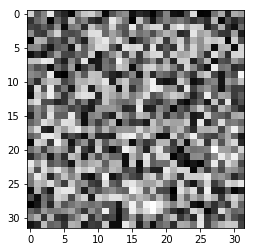

In [394]:
plt.imshow(filters[4], cmap='gray')

In [395]:
def stack_images(image_list, col_num=10, image_size=None, save_path=None, dtype=np.float32):
    '''
    this function is used stack images into a grid, and if needed save the large stacked image
    :param image_list: a list of images with the same size, each image is saved as np.array
    :param grid_size:  the size of image grid
    :param image_size:  if it is not None, resize the images to the given image_size
    :param save_path: if given,save the images
    :return: the stacked large image
    '''
    row_num=int(math.ceil(len(image_list)/col_num))
    
    if image_size is None:  # every image in the image_list has the same size
        dim=image_list[0].shape
        if len(dim) == 2:
            large_im = np.zeros(shape=(dim[0]*row_num, dim[1]*col_num), dtype=dtype)
            for i in range(len(image_list)):
                row_index=i//col_num
                col_index=i-col_num*row_index
                start_1 = row_index * dim[0]
                end_1 = (row_index+1) * dim[0]
                start_2 = col_index * dim[1]
                end_2 = (col_index + 1) * dim[1]
                large_im[start_1: end_1, start_2: end_2] = image_list[i].astype(dtype)
        elif len(dim) == 3:
            large_im = np.zeros(shape=(dim[0]*row_num, dim[1]*col_num, dim[2]), dtype=dtype)
            for i in range(len(image_list)):
                row_index=i//col_num
                col_index=i-col_num*row_index
                start_1 = row_index * dim[0]
                end_1 = (row_index+1) * dim[0]
                start_2 = col_index * dim[1]
                end_2 = (col_index + 1) * dim[1]
                im_array=image_list[i]
                large_im[start_1: end_1, start_2: end_2,:]  = im_array.astype(dtype)
    else: # in this case, each image in the image_list is resized into image_size
        dim0=image_list[0].shape
        dim=image_size
        if len(dim0) == 2:
            large_im = np.zeros(shape=(dim[0]*row_num, dim[1]*col_num), dtype=dtype)
            for i in range(len(image_list)):
                row_index=i//col_num
                col_index=i-col_num*row_index
                start_1 = row_index * dim[0]
                end_1 = (row_index+1) * dim[0]
                start_2 = col_index * dim[1]
                end_2 = (col_index + 1) * dim[1]
                im_array=image_list[i].astype(dtype)
                image0=cv2.resize(im_array.astype(np.uint8), dsize=(image_size[1],image_size[0]), interpolation=cv2.INTER_CUBIC)

                large_im[start_1: end_1, start_2: end_2] = image0
        elif len(dim0) == 3:
            large_im = np.zeros(shape=(dim[0]*row_num, dim[1]*col_num, dim0[2]), dtype=dtype)
            for i in range(len(image_list)):
                row_index=i//col_num
                col_index=i-col_num*row_index
                start_1 = row_index * dim[0]
                end_1 = (row_index+1) * dim[0]
                start_2 = col_index * dim[1]
                end_2 = (col_index + 1) * dim[1]
                im_array=image_list[i].astype(dtype)
                image0=cv2.resize(im_array.astype(np.uint8), dsize=(image_size[1], image_size[0]), interpolation=cv2.INTER_CUBIC)
                large_im[start_1: end_1, start_2: end_2, :] = image0
    if save_path is not None:
        cv2.imwrite(save_path, large_im.astype(np.uint8))
    return large_im

In [396]:
import math

expanded = stack_images(filters, 20)

In [397]:
expanded.shape

(6400, 640)

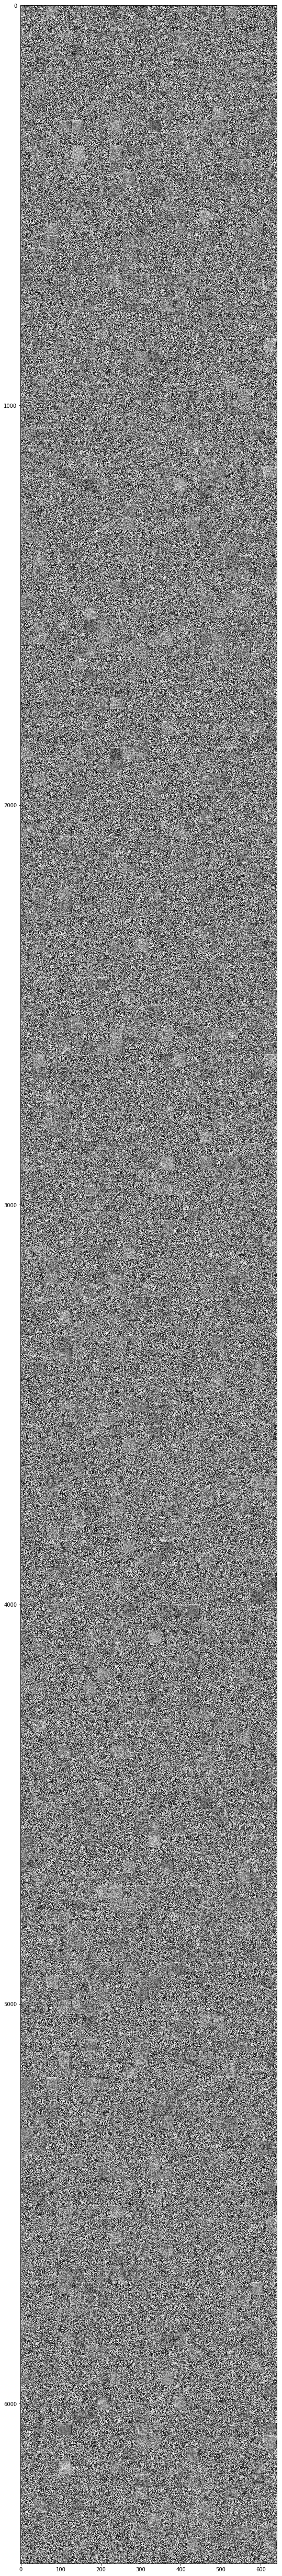

In [398]:
plt.figure(figsize=(160, 90))
plt.imshow(expanded, cmap='gray')

In [421]:
# test_img = list(train_loader)[0][0][63]
test_img = list(test_loader)[0][0][60]
test_img = test_img.unsqueeze(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


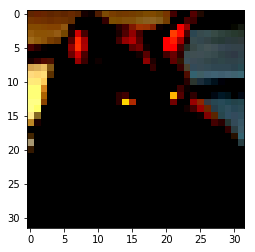

In [422]:
# plt.imshow(np.squeeze(np.squeeze(test_img.detach().numpy(), axis=0), axis=0), cmap='gray')
plt.imshow(np.moveaxis(np.squeeze(test_img.detach().numpy(), axis=0), 0, -1))

In [445]:
model.eval()
model.alpha = 3
result = model(test_img.cuda()).cpu()

result_np = result.detach().numpy()
# result = np.squeeze(np.squeeze(result_np, axis=0), axis=0)
result = np.moveaxis(np.squeeze(result_np, axis=0), 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


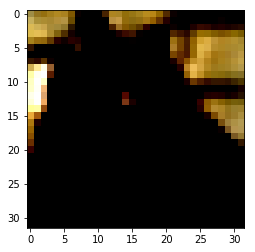

In [446]:
plt.imshow(result, cmap='gray')
# plt.imshow(result)

In [408]:
print(model.alpha)

4


In [290]:
model.training

False